In [2]:
%matplotlib inline
import netCDF4
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import torch

In [3]:
file = '../Data/ena25jan2023.nc'

In [4]:
dataset = netCDF4.Dataset(file)
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: reference, Surface, ScalarAdvection, ScalarDiffusion, VelocityState, ScalarState, DiagnosticState, MicroBase, DiagnosticsTurbulence, DiagnosticsClouds, DiagnosticsCase, RRTMG


In [5]:
for group_name in dataset.groups:
    print(f"Group: {group_name}")   
    group = dataset.groups[group_name]
    print(group)
group_list = list(dataset.groups.keys())

Group: reference
<class 'netCDF4._netCDF4.Group'>
group /reference:
    dimensions(sizes): z(270), z_edge(271)
    variables(dimensions): float64 z(z), float64 z_edge(z_edge), float64 P0(z), float64 P0_edge(z_edge), float64 T0(z), float64 T0_edge(z_edge), float64 rho0(z), float64 rho0_edge(z_edge), float64 alpha0(z), float64 alpha0_edge(z_edge), float64 exner(z), float64 exner_edge(z_edge)
    groups: 
Group: Surface
<class 'netCDF4._netCDF4.Group'>
group /Surface:
    dimensions(sizes): 
    variables(dimensions): 
    groups: timeseries, profiles
Group: ScalarAdvection
<class 'netCDF4._netCDF4.Group'>
group /ScalarAdvection:
    dimensions(sizes): 
    variables(dimensions): 
    groups: timeseries, profiles
Group: ScalarDiffusion
<class 'netCDF4._netCDF4.Group'>
group /ScalarDiffusion:
    dimensions(sizes): 
    variables(dimensions): 
    groups: timeseries, profiles
Group: VelocityState
<class 'netCDF4._netCDF4.Group'>
group /VelocityState:
    dimensions(sizes): 
    variables(d

In [6]:
cloud_ds = xr.open_dataset(file, group = 'DiagnosticsClouds/profiles')
print("Dimensions: ", cloud_ds.dims)
print("Number of variables: ", len(cloud_ds.data_vars))
print("Variables: ", cloud_ds.data_vars)

Dimensions:  FrozenMappingWarningOnValuesAccess({'time': 721, 'z': 270, 'z_edge': 271})
Number of variables:  124
Variables:  Data variables:
    cloud_frac                   (time, z) float64 2MB ...
    core_frac                    (time, z) float64 2MB ...
    u_core                       (time, z) float64 2MB ...
    v_core                       (time, z) float64 2MB ...
    w_core                       (time, z) float64 2MB ...
    u_cloud                      (time, z) float64 2MB ...
    v_cloud                      (time, z) float64 2MB ...
    w_cloud                      (time, z) float64 2MB ...
    qv_cloud                     (time, z) float64 2MB ...
    qv_core                      (time, z) float64 2MB ...
    qc_cloud                     (time, z) float64 2MB ...
    qc_core                      (time, z) float64 2MB ...
    qr_cloud                     (time, z) float64 2MB ...
    qr_core                      (time, z) float64 2MB ...
    qnc_cloud                   

In [7]:
for var in cloud_ds.data_vars:
    print(f'{var}: {cloud_ds[var].attrs["long_name"]}, {cloud_ds[var].attrs["units"]}')

cloud_frac: Cloud fraction, 
core_frac: Core fraction, 
u_core: u velocity core conditional mean, m/s
v_core: v velocity core conditional mean, m/s
w_core: w velocity core conditional mean, m/s
u_cloud: u velocity cloud conditional mean, m/s
v_cloud: v velocity cloud conditional mean, m/s
w_cloud: w velocity cloud conditional mean, m/s
qv_cloud: None cloud, None
qv_core: None core, None
qc_cloud: cloud-water mixing ratio cloud, kg kg^-1
qc_core: cloud-water mixing ratio core, kg kg^-1
qr_cloud: rain-water mixing ratio cloud, kg kg^-1
qr_core: rain-water mixing ratio core, kg kg^-1
qnc_cloud: cloud droplet number concentraiton cloud, kg kg^-1
qnc_core: cloud droplet number concentraiton core, kg kg^-1
qnr_cloud: rain drop number concentration cloud, kg kg^-1
qnr_core: rain drop number concentration core, kg kg^-1
qna_cloud: aerosol number concentration cloud, kg kg^-1
qna_core: aerosol number concentration core, kg kg^-1
qna_nucl_cloud: regeneration aerosol number concentration cloud, k

In [8]:
qc_autoconv_cloud = cloud_ds['qc_autoconv_cloud']
print(str(qc_autoconv_cloud) + '\n')
nc_autoconv_cloud = cloud_ds['nc_autoconv_cloud']
print(str(nc_autoconv_cloud) + '\n')
qr_autoconv_cloud = cloud_ds['qr_autoconv_cloud']
print(str(qr_autoconv_cloud) + '\n')
nr_autoconv_cloud = cloud_ds['nr_autoconv_cloud']
print(str(nr_autoconv_cloud) + '\n')
auto_cldmsink_b_cloud = cloud_ds['auto_cldmsink_b_cloud']
print(str(auto_cldmsink_b_cloud) + '\n')

<xarray.DataArray 'qc_autoconv_cloud' (time: 721, z: 270)> Size: 2MB
[194670 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04 4.32e+04
  * z        (z) float64 2kB 5.0 15.0 25.0 ... 2.675e+03 2.685e+03 2.695e+03
Attributes:
    long_name:      cloud water autoconversion mass cloud
    units:          kg kg^-1
    standard_name:  None_{cloud}

<xarray.DataArray 'nc_autoconv_cloud' (time: 721, z: 270)> Size: 2MB
[194670 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04 4.32e+04
  * z        (z) float64 2kB 5.0 15.0 25.0 ... 2.675e+03 2.685e+03 2.695e+03
Attributes:
    long_name:      cloud water autoconversion number cloud
    units:          kg^-1
    standard_name:  None_{cloud}

<xarray.DataArray 'qr_autoconv_cloud' (time: 721, z: 270)> Size: 2MB
[194670 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04

In [9]:
qc_autoconv_cloud.shape #(time, height)

(721, 270)

In [10]:
qc_autoconv_cloud.time.values

array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
         480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
         960.,  1020.,  1080.,  1140.,  1200.,  1260.,  1320.,  1380.,
        1440.,  1500.,  1560.,  1620.,  1680.,  1740.,  1800.,  1860.,
        1920.,  1980.,  2040.,  2100.,  2160.,  2220.,  2280.,  2340.,
        2400.,  2460.,  2520.,  2580.,  2640.,  2700.,  2760.,  2820.,
        2880.,  2940.,  3000.,  3060.,  3120.,  3180.,  3240.,  3300.,
        3360.,  3420.,  3480.,  3540.,  3600.,  3660.,  3720.,  3780.,
        3840.,  3900.,  3960.,  4020.,  4080.,  4140.,  4200.,  4260.,
        4320.,  4380.,  4440.,  4500.,  4560.,  4620.,  4680.,  4740.,
        4800.,  4860.,  4920.,  4980.,  5040.,  5100.,  5160.,  5220.,
        5280.,  5340.,  5400.,  5460.,  5520.,  5580.,  5640.,  5700.,
        5760.,  5820.,  5880.,  5940.,  6000.,  6060.,  6120.,  6180.,
        6240.,  6300.,  6360.,  6420.,  6480.,  6540.,  6600.,  6660.,
      

In [11]:
def plot_time_series_height(data, height_index):
    data_height = data.isel(z = height_index)
    plt.figure()
    data_height.plot()
    plt.title(f'{data.long_name} at Height Level {height_index} (z={data.coords["z"].values[height_index]} m)')
    plt.xlabel('Time (s)')
    plt.ylabel(f'{data.units}')
    plt.show()

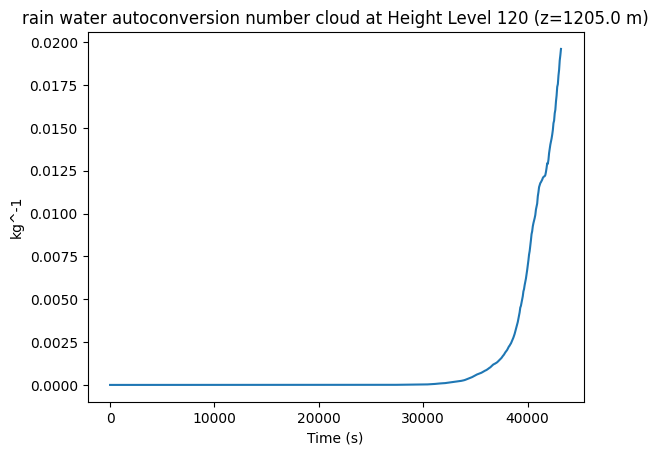

In [12]:
plot_time_series_height(nr_autoconv_cloud, 120)

In [13]:
for group in group_list:
    try:
        ds = xr.open_dataset(file, group = group + '/profiles')
        print("Group name: ", group)
        for var in ds.data_vars:
            print(f'{var}: {ds[var].attrs["long_name"]}, {ds[var].attrs["units"]}')
        print("\n")
    except:
        print("No profiles in group: ", group)
    

No profiles in group:  reference
Group name:  Surface


Group name:  ScalarAdvection
wqv_resolved: Resolved flux of qv, m s^{-1} None
wqc_resolved: Resolved flux of qc, m s^{-1} kg kg^-1
wqr_resolved: Resolved flux of qr, m s^{-1} kg kg^-1
wqnc_resolved: Resolved flux of qnc, m s^{-1} kg kg^-1
wqnr_resolved: Resolved flux of qnr, m s^{-1} kg kg^-1
wqna_resolved: Resolved flux of qna, m s^{-1} kg kg^-1
wqna_nucl_resolved: Resolved flux of qna_nucl, m s^{-1} kg kg^-1
ws_resolved: Resolved flux of s, m s^{-1} K
wT_resolved: Resolved flux of temperature, m s^{-1} K
wthetali_resolved: Resolved flux of liquid-ice potential temperature, m s^{-1} K


Group name:  ScalarDiffusion
wqv_sgs: SGS flux of qv, m s^{-1} None
wqc_sgs: SGS flux of qc, m s^{-1} kg kg^-1
wqr_sgs: SGS flux of qr, m s^{-1} kg kg^-1
wqnc_sgs: SGS flux of qnc, m s^{-1} kg kg^-1
wqnr_sgs: SGS flux of qnr, m s^{-1} kg kg^-1
wqna_sgs: SGS flux of qna, m s^{-1} kg kg^-1
wqna_nucl_sgs: SGS flux of qna_nucl, m s^{-1} kg kg^-1
ws_sg

In [14]:
print(qc_autoconv_cloud.name)

qc_autoconv_cloud


In [15]:
print(qc_autoconv_cloud.data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.62277415e-14 7.58616055e-14 7.59719534e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.32443613e-14 7.30610096e-14 7.33637341e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.20747614e-14 7.19553155e-14 7.21639418e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [16]:
THRESHOLD = 1e-6
def find_nonzero_threshold(dataset, num_values):
    index_list = []
    for i in range(dataset.shape[1]):
        array = dataset.isel(z = i).data
        count = np.count_nonzero(array >= THRESHOLD)
        if count > num_values:
            index_list.append(i)
    return index_list

In [17]:
def extract_data(dataset, index_list):
    data_list = []
    for index in index_list:
        data_list.append(dataset[:, index])
    data_array = np.array(data_list)
    return data_array

In [18]:
def data_profile(data):
    print(f"Mean: {np.mean(data)}")
    print(f"Variance: {np.var(data)}")
    print(f"Min: {np.min(data)}")
    print(f"Max: {np.max(data)}")

In [19]:
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [49]:
index_list = find_nonzero_threshold(qc_autoconv_cloud, 0.75 * qc_autoconv_cloud.shape[0])
print(len(index_list))
def prepare_dataset(dataset, log):
    dataset_copy = dataset.values
    if log:
        dataset_copy = np.log(dataset_copy, out = np.zeros_like(dataset_copy, dtype=np.float64), where = (dataset_copy > 0))
        # dataset_copy = np.nan_to_num(dataset_copy, nan = 0)
    data = extract_data(dataset_copy, index_list)
    data = min_max_normalize(data)
    return data

27


In [50]:
# qc_autoconv_cloud_log = np.log(qc_autoconv_cloud_data, where = qc_autoconv_cloud_data > 0)
qc_autoconv_cloud_norm = prepare_dataset(qc_autoconv_cloud, False)
data_profile(qc_autoconv_cloud_norm)

Mean: 0.34698925859183904
Variance: 0.08311474495906797
Min: 0.0
Max: 1.0


(array([29., 22., 21., 48., 10., 12., 14., 21., 18., 16., 15., 13., 19.,
        14., 18., 27., 25., 15., 13., 17., 65., 62., 59., 62., 86.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

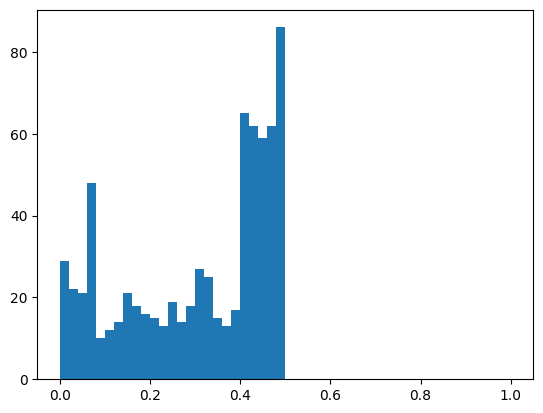

In [48]:
plt.hist(qc_autoconv_cloud_norm[10,:], bins = 50, range = (0, 1))

In [23]:
print(nc_autoconv_cloud.values)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00050406 0.00050207 0.00050475 ... 0.         0.         0.        ]
 [0.00048514 0.00048459 0.00048874 ... 0.         0.         0.        ]
 [0.00047852 0.00047839 0.00048155 ... 0.         0.         0.        ]]


In [24]:
nc_autoconv_cloud = cloud_ds['nc_autoconv_cloud']

In [25]:
data_profile(nc_autoconv_cloud.values)

Mean: 4515107.5178832635
Variance: 221399959463769.4
Min: 0.0
Max: 74052322.35668987


In [26]:
nc_autoconv_cloud.time.values

array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
         480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
         960.,  1020.,  1080.,  1140.,  1200.,  1260.,  1320.,  1380.,
        1440.,  1500.,  1560.,  1620.,  1680.,  1740.,  1800.,  1860.,
        1920.,  1980.,  2040.,  2100.,  2160.,  2220.,  2280.,  2340.,
        2400.,  2460.,  2520.,  2580.,  2640.,  2700.,  2760.,  2820.,
        2880.,  2940.,  3000.,  3060.,  3120.,  3180.,  3240.,  3300.,
        3360.,  3420.,  3480.,  3540.,  3600.,  3660.,  3720.,  3780.,
        3840.,  3900.,  3960.,  4020.,  4080.,  4140.,  4200.,  4260.,
        4320.,  4380.,  4440.,  4500.,  4560.,  4620.,  4680.,  4740.,
        4800.,  4860.,  4920.,  4980.,  5040.,  5100.,  5160.,  5220.,
        5280.,  5340.,  5400.,  5460.,  5520.,  5580.,  5640.,  5700.,
        5760.,  5820.,  5880.,  5940.,  6000.,  6060.,  6120.,  6180.,
        6240.,  6300.,  6360.,  6420.,  6480.,  6540.,  6600.,  6660.,
      

In [54]:
nc_autoconv_cloud_norm = prepare_dataset(nc_autoconv_cloud, False)
data_profile(nc_autoconv_cloud_norm)

Mean: 0.5739292110465752
Variance: 0.10364709051542997
Min: 0.0
Max: 1.0


In [52]:
print(nc_autoconv_cloud_norm)

[[0.         0.         0.         ... 0.27144982 0.26919781 0.26727654]
 [0.         0.         0.         ... 0.3095276  0.30778704 0.30604588]
 [0.         0.         0.         ... 0.35100798 0.34906664 0.34763457]
 ...
 [0.         0.         0.         ... 0.81558851 0.81662104 0.81731127]
 [0.         0.         0.         ... 0.77788628 0.77840337 0.77899863]
 [0.         0.         0.         ... 0.70780116 0.70955247 0.71134256]]


(array([29.,  0.,  0.,  0.,  3.,  3.,  5., 14.,  5.,  3.,  3.,  3.,  4.,
         4.,  7., 16.,  6.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  4.,
         4.,  6.,  7., 11., 11.,  9., 12., 20., 41., 37., 30., 35., 34.,
        62., 51., 53., 64., 98.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

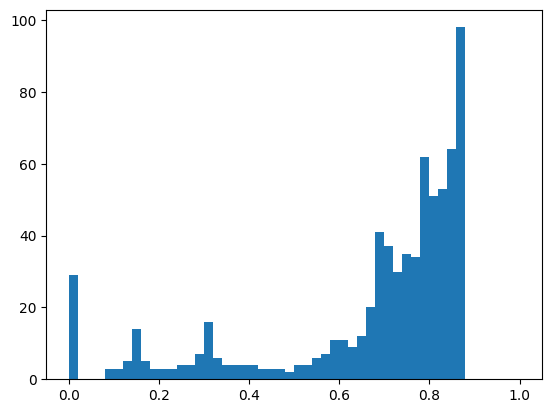

In [53]:
plt.hist(nc_autoconv_cloud_norm[10,:], bins = 50, range = (0, 1))

log makes nc_autoconv distribution even more skewed so that's a no go


In [56]:
qr_autoconv_cloud_norm = prepare_dataset(qr_autoconv_cloud, True)
data_profile(qr_autoconv_cloud_norm)

Mean: 0.6276916067333895
Variance: 0.013766741657197016
Min: 0.0
Max: 1.0


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  4.,  7.,  2.,  6.,  7., 12., 60.,
        47., 37., 30., 47., 60., 37., 56., 64., 49., 58., 58., 49.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

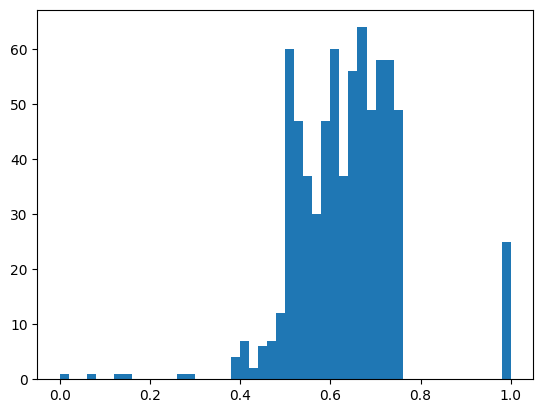

In [31]:
plt.hist(qr_autoconv_cloud_norm[10,:], bins = 50, range = (0, 1))

Very responsive to log as well, better looking distribution

In [60]:
nr_autoconv_cloud_norm = prepare_dataset(nr_autoconv_cloud, True)
data_profile(nr_autoconv_cloud_norm)

Mean: 0.7941891361304855
Variance: 0.01602046084416526
Min: 0.0
Max: 1.0


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,
         7.,  2.,  3.,  6.,  4., 11., 48., 21., 50., 27., 19., 45., 19.,
        64., 26., 46., 61., 32., 47., 54., 45., 49.,  0., 25.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

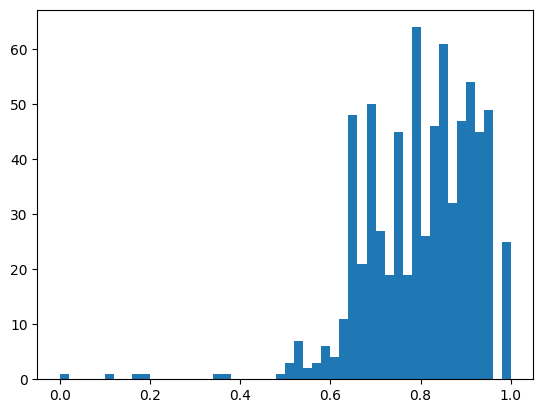

In [62]:
plt.hist(nr_autoconv_cloud_norm[10,:], bins = 50, range = (0, 1))

responsive to log

In [63]:
data_profile(auto_cldmsink_b_cloud.values)

Mean: 7.565485732251578e-17
Variance: 5.350156019920305e-31
Min: 0.0
Max: 1.7971848647695316e-14


In [69]:
auto_cldmsink_b_cloud_norm = prepare_dataset(auto_cldmsink_b_cloud, True)
data_profile(auto_cldmsink_b_cloud_norm)
print(np.min(auto_cldmsink_b_cloud_norm))
print(auto_cldmsink_b_cloud_norm.shape)

Mean: 0.5106370727588699
Variance: 0.020665768544103836
Min: 0.0
Max: 1.0
0.0
(27, 721)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  3.,  3.,  3.,
         0.,  3., 13., 10., 18., 39., 36., 35., 20., 34., 40., 56., 29.,
        57., 65., 49., 70., 63., 43.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

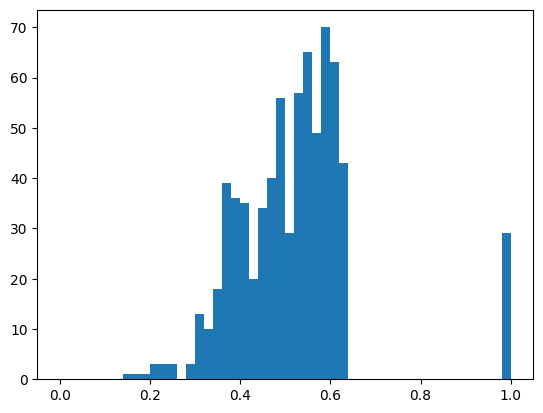

In [70]:
plt.hist(auto_cldmsink_b_cloud_norm[10, :].flatten(), bins = 50, range = (0, 1))

In [40]:
print(np.max(np.log(auto_cldmsink_b_cloud)))

<xarray.DataArray 'auto_cldmsink_b_cloud' ()> Size: 8B
array(-31.64996983)


/Users/HP/Documents/GitHub/Machine-Learning-Cloud-Microphysics/CloudML/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Much more responsive to log, nicer looking distribution
